## Tabular training

In [21]:
# Install libraries on first run
# ! pip install -q ipynb fastai pathlib pandas import_ipynb numpy

In [22]:
from fastai.tabular.all import *
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import import_ipynb
import numpy as np

## Variables

In [23]:
modelName = 'stockScreenerV1.3'
trainingDataName = 'stockData.csv'
trainingFolder = Path.cwd().parent / 'TrainingData'
modelFolder = Path.cwd().parent.parent / 'TrainedModels'

# Training parameters
yNames = ['Future Year Change']
catNames = ['Industry']
contNames = [
    'Open',
    'High', 
    'Low', 
    'Close', 
    'Volume', 
    'Dividends', 
    'Stock Splits', 
    'EV/EBIT', 
    'ROIC'
]
epochs = 10

# Test parameters
testSize = 500 # Number of stocks to test

Then we can have a look at how the data is structured:

In [24]:
dataPath = Path()
df = pd.read_csv(trainingFolder/trainingDataName)
df.head()

,index,Ticker,Industry,EV/EBIT


Some of the columns are continuous (like age) and we will treat them as float numbers we can feed our model directly. Others are categorical (like workclass or education) and we will convert them to a unique index that we will feed to embedding layers. We can specify our categorical and continuous column names, as well as the name of the dependent variable in TabularDataLoaders factory methods:

In [26]:
dls = TabularDataLoaders.from_csv(trainingFolder/trainingDataName, path=dataPath, 
    y_names=yNames,
    cat_names=catNames,
    cont_names=contNames,
    procs = [Categorify, FillMissing, Normalize])

KeyError: "None of [Index(['Future Year Change'], dtype='object')] are in the [columns]"

The last part is the list of pre-processors we apply to our data:

* Categorify is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
* FillMissing will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
* Normalize will normalize the continuous variables (subtract the mean and divide by the std)

To further expose what’s going on below the surface, let’s rewrite this utilizing fastai’s TabularPandas class. We will need to make one adjustment, which is defining how we want to split our data. By default the factory method above used a random 80/20 split, so we will do the same:

In [9]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [ ]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
    y_names=yNames,
    cat_names = catNames,
    cont_names = contNames,
    splits=splits)

c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

Once we build our TabularPandas object, our data is completely preprocessed as seen below:

In [ ]:
to.xs.iloc[:1]

,Industry,EV/EBIT_na,ROIC_na,Open,High,Low,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC
21684,14,1,2,0.070574,0.073036,0.054907,0.055911,-0.212207,-0.055331,-0.008441,0.202489,-0.084463


Now we can build our DataLoaders again:

In [12]:
dls = to.dataloaders(bs=64)

The show_batch method works like for every other application:

In [ ]:
dls.show_batch()

,Industry,EV/EBIT_na,ROIC_na,Open,High,Low,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC,Future Year Change
0,Semiconductors,False,True,138.796463,139.217438,136.420365,138.543900,5.079800e+06,-5.364923e-11,2.967173e-11,51.084675,0.041046,0.081429
1,Software - Application,False,True,98.849999,98.969003,96.318999,98.001000,1.200700e+07,-5.364923e-11,2.967173e-11,93.444194,0.041046,0.605147
2,Banks - Diversified,False,True,58.868396,59.545725,58.765502,59.537155,1.384399e+06,-5.364923e-11,2.967173e-11,1.212148,0.041046,0.105512
3,Railroads,False,True,83.910116,84.153146,83.181029,83.639053,8.977996e+05,-5.364923e-11,2.967173e-11,28.509910,0.041046,-0.129915
4,Copper,False,True,67.364654,68.073298,66.761000,67.942058,8.973896e+05,-5.364923e-11,2.967173e-11,35.153340,0.041046,0.011474
5,Software - Infrastructure,False,True,104.949998,111.180001,101.749999,110.379997,1.682030e+07,-5.364923e-11,2.967173e-11,16.856004,0.041046,-0.259648
6,Electronic Gaming & Multimedia,False,True,105.073419,106.526398,104.946648,105.170930,1.178600e+06,-5.364923e-11,2.967173e-11,-2.589209,0.041046,-0.232678
7,Semiconductor Equipment & Materials,False,True,85.416212,86.325408,84.429643,85.648354,5.808100e+06,-5.364923e-11,2.967173e-11,16.697395,0.041046,0.668468
8,Conglomerates,False,True,195.549452,196.333586,192.316116,194.116716,2.656800e+06,-5.364923e-11,2.967173e-11,25.940784,0.041046,0.063171
9,Other Industrial Metals & Mining,False,True,54.460019,55.307588,54.213457,55.045616,3.839649e+06,-5.364923e-11,2.967173e-11,17.759217,0.041046,-0.069849


We can define a model using the tabular_learner method. When we define our model, fastai will try to infer the loss function based on our y_names earlier.

Note: Sometimes with tabular data, your y’s may be encoded (such as 0 and 1). In such a case you should explicitly pass y_block = CategoryBlock in your constructor so fastai won’t presume you are doing regression.

In [14]:
learn = tabular_learner(dls, metrics=[rmse, mae])

And we can train that model with the fit_one_cycle method (the fine_tune method won’t be useful here since we don’t have a pretrained model).

In [ ]:
print(f"Training {modelName} for {epochs} epochs")
learn.fit_one_cycle(epochs)

Training stockScreenerV1.2 for 30 epochs


epoch,train_loss,valid_loss,_rmse,mae,time
0,0.637624,35.714199,5.976136,0.463989,00:13
1,0.691556,2.254583,1.501527,0.383275,00:12
2,0.635766,1.296716,1.138735,0.396097,00:12
3,0.771856,226.294052,15.043074,0.602890,00:12
4,0.909905,30615.939453,174.974152,2.723123,00:12
5,0.739600,150875.421875,388.427124,5.529497,00:12
6,0.530800,1.798114,1.340938,0.377387,00:12
7,0.504558,0.792111,0.890006,0.348990,00:12
8,0.381430,34.992317,5.915430,0.417845,00:12
9,0.646620,67.257965,8.201095,0.443451,00:12


We can then have a look at some training predictions:

In [ ]:
learn.show_results(max_n=15)

,Industry,EV/EBIT_na,ROIC_na,Open,High,Low,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC,Future Year Change,Future Year Change_pred
0,27.0,1.0,2.0,-0.195230,-0.199377,-0.192640,-0.195063,-0.295323,-0.055331,-0.008441,-0.064132,-0.084463,0.160535,0.122780
1,3.0,1.0,2.0,-0.360684,-0.363172,-0.359859,-0.362150,-0.271056,-0.055331,-0.008441,-1.726868,-0.084463,-0.168442,0.063558
2,15.0,1.0,2.0,-0.370265,-0.371180,-0.369002,-0.370129,-0.244529,-0.055331,-0.008441,-1.189551,-0.084463,0.850400,0.369445
3,2.0,1.0,1.0,0.391343,0.403028,0.383819,0.413933,0.997611,-0.055331,-0.008441,1.367149,-1.505277,0.155710,0.076198
4,5.0,1.0,2.0,-0.096016,-0.098825,-0.090149,-0.096778,-0.215847,-0.055331,-0.008441,-0.367648,-0.084463,0.210441,0.192785
5,5.0,1.0,2.0,0.024978,0.018818,0.028942,0.023256,-0.244559,-0.055331,-0.008441,-0.231389,-0.084463,0.158478,0.150512
6,10.0,1.0,1.0,-0.097778,-0.103702,-0.097110,-0.099838,0.935281,-0.055331,-0.008441,0.357256,-0.964706,0.159195,0.304741
7,16.0,1.0,2.0,0.777116,0.760871,0.760593,0.749011,-0.174918,-0.055331,-0.008441,0.199467,-0.084463,-0.120715,0.438989
8,3.0,1.0,2.0,-0.234988,-0.239426,-0.233278,-0.236333,-0.286485,-0.055331,-0.008441,-1.795418,-0.084463,0.237113,0.068476
9,31.0,1.0,2.0,-0.377141,-0.374717,-0.374709,-0.372923,0.153226,-0.055331,-0.008441,0.511461,-0.084463,0.796879,0.151013


## Evaluation

In [ ]:
import stockFetcher

C:\Users\Gamer\AppData\Local\Temp\ipykernel_9308\440718008.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_test_data = pd.concat(test_data_list, ignore_index=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origina

Logged evaluation results to c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\TrainedModels\modelEvaluations.csv


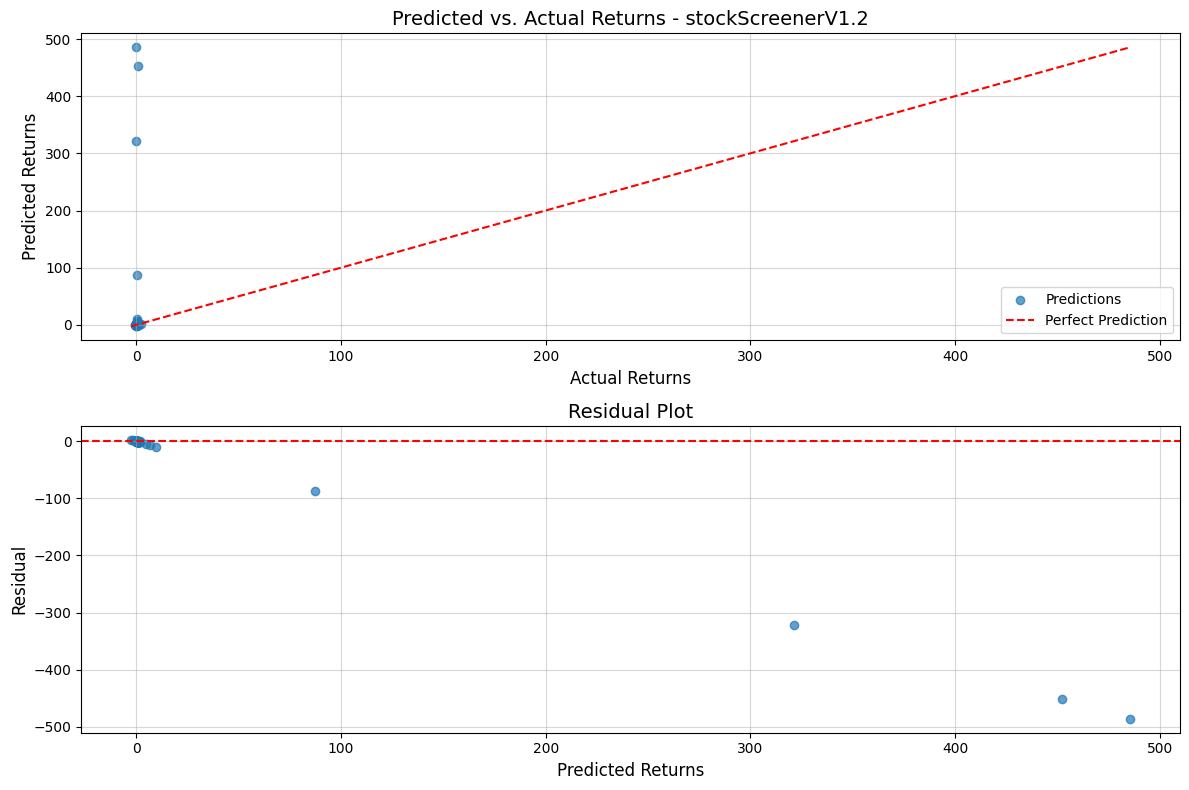


Evaluation Results:
MAE: 16.897
RMSE: 81.451
R2: -41792.926


In [20]:
def evaluate_model(learn, test_tickers, model_name, model_folder, cont_names, cat_names):
    """
    Evaluate a fastai model on a list of test tickers and log the results.
    
    Args:
        learn: fastai Learner object
        test_tickers (list): List of ticker symbols to test on
        model_name (str): Name of the model for logging
        model_folder (Path): Path to save evaluation results
        cont_names (list): List of continuous feature names
        cat_names (list): List of categorical feature names
    """
    all_predictions = []
    all_actuals = []
    test_data_list = []
    
    # Collect test data for all tickers
    for ticker in test_tickers:
        try:
            # Get test data
            test_data = stockFetcher.getTickerDataFrom1YrAgo(ticker)
            if test_data.empty:
                print(f"Skipping {ticker} due to missing data")
                continue
            
            test_data_list.append(test_data)
            
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            continue
    
    if not test_data_list:
        print("No valid test data collected")
        return None, None, None
    
    # Combine all test data
    combined_test_data = pd.concat(test_data_list, ignore_index=True)
    
    # Create fastai test dataloader
    test_dl = learn.dls.test_dl(combined_test_data)
    
    # Get predictions
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Convert to numpy arrays
    predictions = preds.numpy()
    actuals = targs.numpy()
    
    # Create DataFrame for analysis
    results_df = pd.DataFrame({
        'Predicted': predictions.flatten(),
        'Actual': actuals.flatten()
    })

    # Calculate residuals
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Define outlier threshold (2 standard deviations)
    outlier_threshold = 2 * results_df['Residual'].std()

    # Filter outliers
    filtered_df = results_df[abs(results_df['Residual']) <= outlier_threshold]

    # Calculate metrics
    mae = np.mean(np.abs(filtered_df['Residual']))
    rmse = np.sqrt(np.mean(filtered_df['Residual']**2))
    r2 = 1 - (np.sum(filtered_df['Residual']**2) / 
              np.sum((filtered_df['Actual'] - filtered_df['Actual'].mean())**2))

    # Log results
    log_evaluation(model_name, mae, rmse, r2, model_folder)
    
    # Create visualizations
    plot_results(filtered_df, model_name, model_folder)
    
    return mae, rmse, r2

def log_evaluation(model_name, mae, rmse, r2, model_folder):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "ModelName": model_name,
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M')
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plot_results(filtered_df, model_name, model_folder):
    """Create and save visualization plots"""
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    plt.subplot(2, 1, 1)
    actuals = filtered_df['Actual']
    predictions = filtered_df['Predicted']
    plt.scatter(actuals, predictions, alpha=0.7, label='Predictions')
    
    # Perfect prediction line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='red', linestyle='--', label='Perfect Prediction')
    
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns', fontsize=12)
    plt.ylabel('Predicted Returns', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    
    # Residual plot
    plt.subplot(2, 1, 2)
    plt.scatter(predictions, filtered_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot', fontsize=14)
    plt.xlabel('Predicted Returns', fontsize=12)
    plt.ylabel('Residual', fontsize=12)
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    
    # Show plot
    plt.show()

# Function to get random test tickers
def get_random_test_tickers(n_tickers=5):
    """
    Get random US tickers that aren't in the training set.
    
    Args:
        n_tickers (int): Number of test tickers to return
        
    Returns:
        list: List of ticker symbols
    """
    # Get all available tickers
    all_us_tickers = stockFetcher.symbols
    
    # Get training tickers
    training_data = pd.read_csv(trainingFolder / trainingDataName)
    training_tickers = set(training_data['Symbol'].unique() if 'Symbol' in training_data.columns else [])
    
    # Filter out training tickers
    available_tickers = [ticker for ticker in all_us_tickers if ticker not in training_tickers]
    
    # Randomly select tickers
    if len(available_tickers) < n_tickers:
        print(f"Warning: Only {len(available_tickers)} tickers available")
        return available_tickers
    
    return np.random.choice(available_tickers, size=n_tickers, replace=False).tolist()

# Example usage:
if __name__ == "__main__":
    
    # Get random test tickers
    test_tickers = get_random_test_tickers(n_tickers=testSize)
    
    # Evaluate model (replace learn with your actual learner)
    mae, rmse, r2 = evaluate_model(
        learn=learn,  # Your fastai learner
        test_tickers=test_tickers,
        model_name=modelName,
        model_folder=modelFolder,
        cont_names=contNames,
        cat_names=catNames
    )
    
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2: {r2:.3f}")

## Export the model

In [198]:
learn.export(modelFolder / f'{modelName}.pkl')

## Tests (recommended to use the app instead, but feel free to use the tests below)

In [199]:
from stockFetcher import getTickerData


To get prediction on a new dataframe, you can use the test_dl method of the DataLoaders. That dataframe does not need to have the dependent variable in its column.

In [200]:
predictionTarget = 'AAPL'

test_df = getTickerData(predictionTarget)

# Ensure test_df is a DataFrame
if isinstance(test_df, dict):
	test_df = pd.DataFrame([test_df])

dl = learn.dls.test_dl(test_df)
test_df.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermed

,Open,High,Low,Close,Volume,Dividends,Stock Splits,EV/EBIT,Market Cap,ROIC,Industry
0,232.119995,232.289993,228.479996,229.979996,68247100,0.0,0.0,59.880474,3.458416e+12,0.013193,Consumer Electronics


In [201]:
prediction = learn.get_preds(dl=dl)
print(f"Prediction for {predictionTarget}:")
print(f"{prediction[0][0][0].item() * 100:.2f}%")

Prediction for AAPL:
-2.64%


Note:
Since machine learning models can’t magically understand categories it was never trained on, the data should reflect this. If there are different missing values in your test data you should address this before training